# ADS Midterm 2019

## Theoretic part

In [0]:
# import packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Midterm: FHV Traffic Modeling for Real-Time Autonomous Vehicle Solutions in JFK

Transportation network models are essential to transportation operations and planning. A simple yet well-designed linear model can provide us insights on the traffic demand. We are going to model the outgoing traffic around JFK, one of the busiest transportation hubs in NYC. 
In this test, you'll be asked to:
* Find possible correlations from observations
* Incoperate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

We will be importing the dataset `JFK60.csv` providing FHV ridership and arrivals at the airport aggregated on the hourly basis:
* `fhv`: Number of FHV (For Hired Vehicle) departing from JFK. This is our target variable.
* `arrival`: Number of incoming domestic flights arriving JFK, which is assumed to provide a basis for future FHV demand

In [0]:
# import and curate the dataset
dataset = pd.read_csv("JFK60.csv")

In [0]:
dataset.head()

,date,arrival,fhv
0,18/1/1 0:00,6,263
1,18/1/1 1:00,6,138
2,18/1/1 2:00,2,50
3,18/1/1 3:00,0,24
4,18/1/1 4:00,2,45


In [0]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
dataset.date = pd.to_datetime(dataset.date, format='%y/%m/%d %H:%M')

In [0]:
#get day from beginning of the year, hour and day of the week from datetime
dataset['hour']=pd.DatetimeIndex(dataset.date).hour

In [0]:
#get day of the week; monday - 0, sunday - 6
dataset['dow']=pd.DatetimeIndex(dataset.date).weekday

In [0]:
#get day from beginning of the year
dataset['day']=((dataset.date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

In [0]:
dataset.head()

,date,arrival,fhv,hour,dow,day
0,2018-01-01 00:00:00,6,263,0,0,0
1,2018-01-01 01:00:00,6,138,1,0,0
2,2018-01-01 02:00:00,2,50,2,0,0
3,2018-01-01 03:00:00,0,24,3,0,0
4,2018-01-01 04:00:00,2,45,4,0,0


In [0]:
#add time-lagged arrivals (1,2,3,4,5,6 hours before)
maxlag = 12
lagdata=pd.DataFrame([])
for lag in range(1,maxlag+1):
        varname = 'lag' + str(lag)
        lagdata[varname] = dataset['arrival'].iloc[maxlag-lag:len(dataset)-lag].reset_index(drop = True)
datasetL = pd.concat([dataset.loc[maxlag:].reset_index(drop = True), lagdata.reset_index(drop = True)], axis = 1, sort = False)

In [0]:
datasetL.head()

,date,arrival,fhv,hour,dow,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 12:00:00,10,357,12,0,0,7,17,13,11,19,11,16,2,0,2,6,6
1,2018-01-01 13:00:00,18,390,13,0,0,10,7,17,13,11,19,11,16,2,0,2,6
2,2018-01-01 14:00:00,19,606,14,0,0,18,10,7,17,13,11,19,11,16,2,0,2
3,2018-01-01 15:00:00,28,601,15,0,0,19,18,10,7,17,13,11,19,11,16,2,0
4,2018-01-01 16:00:00,15,676,16,0,0,28,19,18,10,7,17,13,11,19,11,16,2


## Task 1. Data Exploration
### Q1 (5pts). Print some dataset characteristics: number of records, total number of FHV trips, total number of arriving flights

In [0]:
nsamp = len(dataset)
# this is the duration of our observations: tail - head + 1 
print('The time period for this dataset is: ',len(dataset.day.unique()))
print('The number of observations are: ',nsamp)
print('Total ridership are: ', sum(dataset['fhv']))
print('Total arrival flights are: ', sum(dataset['arrival']))
print(dataset.describe())
# display the first five rows of the dataframe
dataset.head(5)

('The time period for this dataset is: ', 365)
('The number of observations are: ', 8760)
('Total ridership are: ', 3499619)
('Total arrival flights are: ', 126617)
           arrival          fhv         hour          dow          day
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000
mean     14.453995   399.499886    11.500000     2.991781   182.000000
std       7.895781   218.861141     6.922582     2.003519   105.372043
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%      10.000000   250.000000     5.750000     1.000000    91.000000
50%      16.000000   389.000000    11.500000     3.000000   182.000000
75%      20.000000   543.000000    17.250000     5.000000   273.000000
max      38.000000  1772.000000    23.000000     6.000000   364.000000


,date,arrival,fhv,hour,dow,day
0,2018-01-01 00:00:00,6,263,0,0,0
1,2018-01-01 01:00:00,6,138,1,0,0
2,2018-01-01 02:00:00,2,50,2,0,0
3,2018-01-01 03:00:00,0,24,3,0,0
4,2018-01-01 04:00:00,2,45,4,0,0


## Q2 (10pts). Visualize the timeline of FHV rides and arriving flights over the first month (January, 2018)

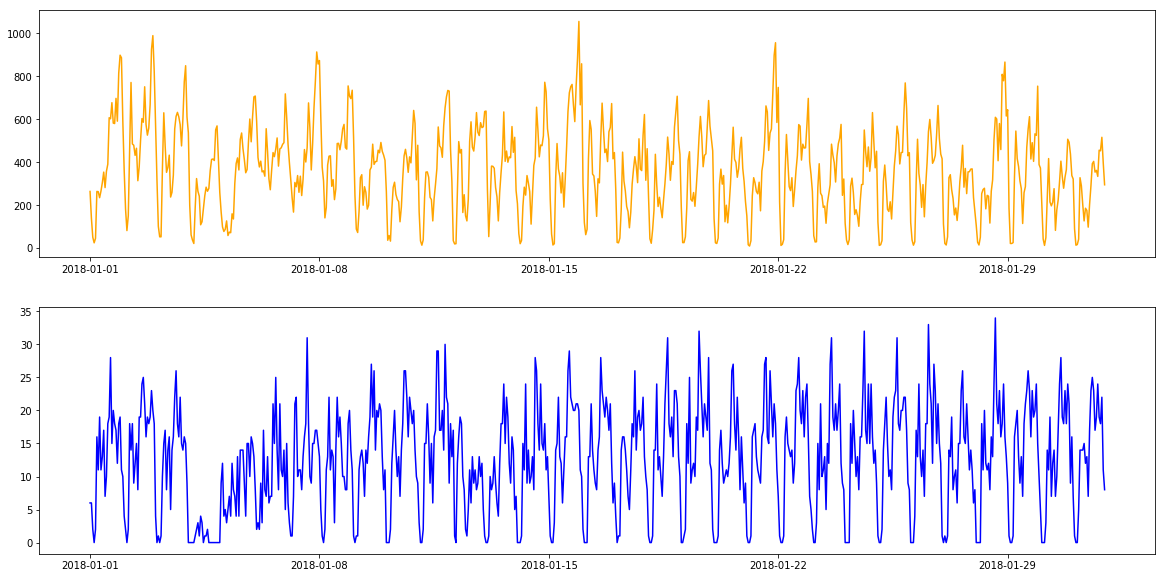

In [0]:
# plot the `fhv` and `arrival` on the timelibe to see if they share similiar tendency
# Note that here we only plot January data here for better view. 744 = 24 * 31
# You need to use two subplots here because `arrival` and `fhv` have different scale
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(np.array(dataset.date[0:24*31]),dataset['fhv'][0:24*31], color = 'orange')
plt.subplot(212)
plt.plot(np.array(dataset.date[0:24*31]),dataset['arrival'][0:24*31],color = 'blue')
plt.show()

### Q3 (5pts). Report correlation between FHV rides and arriving flights

In [0]:
np.corrcoef(dataset.arrival,dataset.fhv)[0,1]

0.6037327153764892

## Task 2: Build Linear Regression Model of FHV vs Arrival data

In [0]:
#split the data into training, validation and test
train=datasetL.loc[datasetL.day<90,:]
valid=datasetL.loc[(datasetL.day>=90)&(datasetL.day<270),:]
test=datasetL.loc[datasetL.day>=270,:]

### Q1 (7pts). Build an OLS model with intercept (you may want to use smf.ols) over `train` using `arrival` as a sole predictor for `fhv` 
Check p-value for arrival. What does it indicate? Report the 99% confidence interval for arrival's coefficient

In [0]:
# Answer
arrivalFHV = smf.ols(formula = 'fhv ~ arrival',data = train).fit()
print(arrivalFHV.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     1333.
Date:                Sat, 09 Nov 2019   Prob (F-statistic):          2.19e-227
Time:                        23:05:58   Log-Likelihood:                -13925.
No. Observations:                2148   AIC:                         2.785e+04
Df Residuals:                    2146   BIC:                         2.787e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    146.8893      6.713     21.882      0.0

In [0]:
## p-value below 5% indicates that one can reject the hypothesis that arrival has no impact on fhv; in fact this hypothesis could be rejected at least at a 99.9% level of confidence

In [0]:
arrivalFHV.conf_int(alpha=0.01).loc['arrival']

0    14.712692
1    16.948656
Name: arrival, dtype: float64

### Q2 (8pts): Consider Historical Impact 
by adding time lags - add all 12 lag variables into the regression above

There is always some delay between passengers arrival and departure (e.g. passing customs, picking up luggage etc). `fhv` might be more related to historical values of flight arrivals (lag) rather than immediate `arrival`. Engineer a formulae with all the following variables and run the regression:
* arrival, lag1, ..., lagN: that happens 1hr, ..., N=12 hr ahead.
Which of the varialbes have statistically significant impact according to p-values?

In [0]:
maxLag = 12
lagFeature = ['lag' + str(i+1) for i in range(0,maxLag)]
lagFHV = smf.ols(formula = 'fhv ~ arrival + ' + '+'.join(lagFeature), data = train).fit()
print(lagFHV.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     234.1
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:05:58   Log-Likelihood:                -13492.
No. Observations:                2148   AIC:                         2.701e+04
Df Residuals:                    2134   BIC:                         2.709e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.0192     11.724      1.708      0.0

## Q3 (5pts): Incorperate Temporal Patterns 
by adding categorical variables for day of week and hour 

From the visualization in task1Q3 you may see that both - `fhv` as well as arrivals follow a somewhat periodic temporal pattern. Intuitively, this is true for most traffic flows following daily rhytms including rush hours and also varying over the course of the week. Usually we add dummy/categorical variables (Boolean variable: 1 for True and 0 for False) to encapsulate people's traveling pattern during different time periods.

Note that it would not make sense to add hour and dow as regular regressors as we can't anticipate their linear numeric impact. Instead expression `C(.)` could be used in the regression formulae in order to treat those variables as categorical adding corresponding dummy variables to account for their possible discrete values.

Perform the regression of fhv agains arrival, lags and temporal categorical variables. Which of the varialbes have statistically significant impact according to p-values?

In [0]:
maxLag=12
lagFeature = ['lag' + str(i+1) for i in range(0,maxLag)]
lm3 = smf.ols(formula = 'fhv ~ arrival + ' + '+'.join(lagFeature) + '+C(hour)+C(dow)', data = train).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     161.8
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:05:58   Log-Likelihood:                -12895.
No. Observations:                2148   AIC:                         2.588e+04
Df Residuals:                    2105   BIC:                         2.612e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       410.3005     21.133     19.415

### Q4 (10pts). Perform feature selection for lag variables
As you may see not all the lag variables have statistically signifant impact on the regression. Maybe some of them are not really relevant?
Try different amounts of lag variables m=0,1,...,12 using a loop for training the above regression over the training sample, report the out-of-sample R2 over the validation sample and pick up m which maximizes it. Evaluate the final regression over test sample.

In [0]:
R2_OS=np.zeros(7)
for m in range(0,7):
    lagFeature = ['lag' + str(i+1) for i in range(0,m)]
    lm4 = smf.ols(formula = 'fhv ~ arrival + ' + '+'.join(lagFeature) + '+C(hour)+C(dow)', data = train).fit()
    R2_OS[m]=r2_score(valid.fhv,lm4.predict(valid))

In [0]:
R2_OS

array([0.68484815, 0.71384878, 0.71439055, 0.71368232, 0.71477931,
       0.71423183, 0.71419596])

In [0]:
m=np.argmax(R2_OS); m

4

In [0]:
lagFeature = ['lag' + str(i+1) for i in range(0,m)]
lm4 = smf.ols(formula = 'fhv ~ arrival + ' + '+'.join(lagFeature) + '+C(hour)+C(dow)', data = train).fit()

In [0]:
r2_score(test.fhv,lm4.predict(test))

0.6732119031283765

In [0]:
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    fhv   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     195.1
Date:                Sat, 09 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:05:59   Log-Likelihood:                -12918.
No. Observations:                2148   AIC:                         2.591e+04
Df Residuals:                    2113   BIC:                         2.610e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       443.4337     17.569     25.240

### Q5 (10pts). Visualize temporal patterns and lag impacts through bar plots
For the best regression above visualize:
- bar plot of hour of the day vs its impact coefficient
- bar plot of day of the week vs its impact coefficient
- bar plot of the lag (0 for immediate arrivals, 1,2,... for lags)

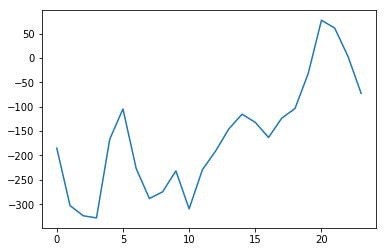

In [0]:
#impact of time of the day
plt.plot(range(24),lm4.params[1:25])

<BarContainer object of 7 artists>

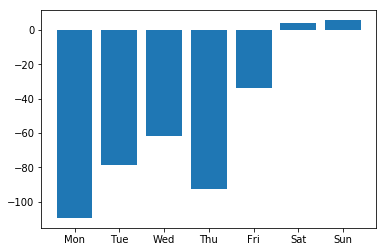

In [0]:
#impact of day of the week
plt.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],lm4.params[25:32])

<BarContainer object of 5 artists>

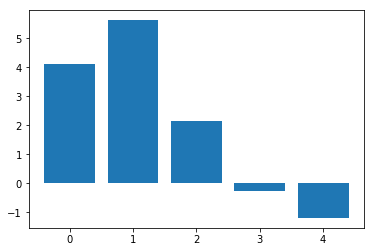

In [0]:
#impact of arrivals
plt.bar(range(5),lm4.params[-5:])

# get p-value and plot them using plt.bar.
# mark their p-value around each bar
lagInterceptFeature = ['Intercept','arrival'] + lagFeature
plt.figure(figsize = (40,5))
plt.bar(lagInterceptFeature, lagFHV.pvalues)
# This is the tagging part
for x,y in zip(lagInterceptFeature, lagFHV.pvalues):
    plt.annotate(s = str(y), # This is the text with point (x,y)
                 xy = (x,y), # This is the point we need to annotate
                 #arrowprops = dict(facecolor = 'black', shrink = 0.05), # This is the style
                 ha = 'center') # This is the position
plt.show()

Please find the optimal choice for Lasso regression. What lag feature should we use here?

## Task 3. Cluster the days of the year based on the relative timeline of their FHV departures from the airport

### Q1 (5pts). From the entire `dataset`, create a dataframe with days as rows, hours as columns and FHV ridership as values (feel free to use pd.pivottable). Normalize by the total daily ridership

In [0]:
dayTimelines=pd.pivot_table(dataset,values='fhv',index='day',columns='hour')

Using this dataframe cluster days with K-means clustering based on their hourly FHV ridership timeline

In [0]:
dayTimelines=dayTimelines.div(dayTimelines.sum(axis=1), axis=0) 

### Q2 (10pts). Try K-means with the differet numbers of clusters k=2..7, reporting average Silhuette score for each. Which k is the "optimal" from Silhuette's standpoint?

In [0]:
for n_clusters in range(2,7): #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = km.fit_predict(dayTimelines)
    #report average Silhouette score
    silhouette_avg = silhouette_score(dayTimelines, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.216129432797
For n_clusters =3, the average silhouette_score is :0.213582241446
For n_clusters =4, the average silhouette_score is :0.144931345567
For n_clusters =5, the average silhouette_score is :0.131368070127
For n_clusters =6, the average silhouette_score is :0.109311031426


### Q3 (15pts). Perform K-means with the optimal k from above. Report the number of occurance of each day of the week within each of the clusters. How would you interpret the clusters based on that? Visualize the aggregated hourly timeline over all the days within each cluster.
Create a dictionary of the cluster numbers corresponding to each day of the year, apply it adding a column "cluster" to the dataframe and use pivot table with aggregation function `count` to collect the numbers above. Also use pivot table to collect total riders per hour of the day within each cluster for further visualization (after appropriate normalization by the grand total).

In [0]:
km = KMeans(n_clusters=2, random_state=1)
cluster_labels = km.fit_predict(dayTimelines)
dayCluster={i:cluster_labels[i] for i in range(len(cluster_labels))}

In [0]:
datasetC=dataset.copy()

In [0]:
datasetC['Cluster']=dataset.day.map(dayCluster)

In [0]:
pd.pivot_table(datasetC,values='date', index='dow',columns='Cluster', aggfunc='count')

Cluster,0,1
dow,,
0,1104,168
1,912,336
2,552,696
3,432,816
4,984,264
5,1176,72
6,72,1176


In [0]:
#second cluster distringuishes Sunday and midweek, while first - beginning and the week as well as Friday, Saturday

In [0]:
#visualize the timeline for each cluster

In [0]:
ClusterTimelines=pd.pivot_table(datasetC,values='fhv', index='hour',columns='Cluster', aggfunc='sum')

In [0]:
ClusterTimelines/=ClusterTimelines.sum(axis=0)

In [0]:
ClusterTimelines.head()

Cluster,0,1
hour,,
0,0.070619,0.045014
1,0.044634,0.020464
2,0.015074,0.006049
3,0.006875,0.003853
4,0.006145,0.005200


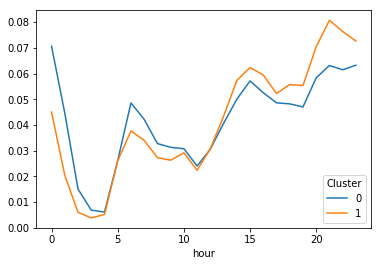

In [0]:
ClusterTimelines.plot()